In [186]:
import numpy as np
import pylab as plt
from scipy.optimize import fsolve
from numpy.linalg import norm, lstsq

# 7.3) Fitting circles

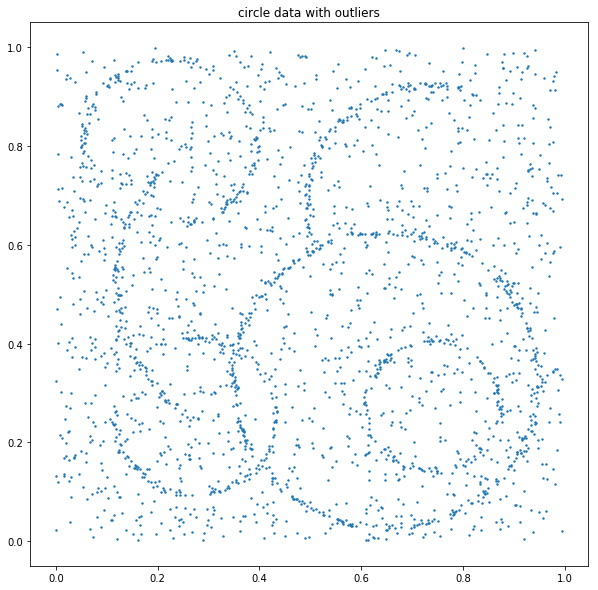

In [10]:
#loading data
circles = np.load('circles.npy')
x_circles = circles[:, 0]
y_circles = circles[:, 1]

#plotting
plt.figure(figsize=(10, 10))
plt.scatter(x_circles, y_circles, s=2)
plt.title('circle data with outliers')
plt.show()

intuitively one would fit six circle segments in this data

## 7.3.1) RANSAC

In [154]:
def circle_eq(params, instances):
    '''function to determine system of equations to fit a circle through three points'''
    
    r, c_x, c_y = params
    
    eq1 = (instances[0,0] - c_x)**2 + (instances[0,1] - c_y)**2 - r**2
    eq2 = (instances[1,0] - c_x)**2 + (instances[1,1] - c_y)**2 - r**2
    eq3 = (instances[2,0] - c_x)**2 + (instances[2,1] - c_y)**2 - r**2
    
    return (eq1, eq2, eq3)

def ransac(data, epsilon, n_tries, equations=circle_eq, n_param=3, plotting=True):
    
    #instantiation
    best_params = []
    best_inliers = []
    best_iter = 0
    
    #trying n_tries times to find a good model
    for i in range(n_tries):
        
        #randomly sample a number of n_param instances from data
        fit_indices = [] #indices in data
        while len(fit_indices) < n_param:
            index = np.random.randint(0, len(data) - 1)
            if index not in fit_indices:
                fit_indices.append(index)
                
        fit_instances = np.take(data, fit_indices, axis=0)
    
        #fit equations to the sampled instances to get a set of parameters
        init_param = np.array([1, 0, 0])
        params = fsolve(equations, init_param, fit_instances)
        c = np.array([params[1], params[2]]) #center of current circle
        r = params[0] #radius of current circle
        
        #find instances within a distance epsilon around the current circle
        d_c = norm(np.subtract(data, c), axis=1) #distances from current circle center
        d = np.absolute(d_c - r) #distance from current circle
        i_in = np.squeeze(np.argwhere(d < epsilon)) #indices of inliers
        
        #updating best model
        if len(i_in) > len(best_inliers):
            best_inliers = i_in
            best_params = params
            best_iter = i
    
    #plot best circle
    if plotting:
        
        print('best circle with', len(best_inliers), 'inliers')
        circle = plt.Circle((best_params[1], best_params[2]), radius=best_params[0], fill=False)
        epsilon1 = plt.Circle((best_params[1], best_params[2]), radius=best_params[0] - epsilon, fill=False)
        epsilon2 = plt.Circle((best_params[1], best_params[2]), radius=best_params[0] + epsilon, fill=False)
        plt.figure(figsize=(10, 10))
        plt.scatter(data[:,0], data[:,1], s=2)
        plt.gca().add_patch(circle)
        plt.gca().add_patch(epsilon1)
        plt.gca().add_patch(epsilon2)
        plt.show()
        
    i_in = best_inliers
    i_out = np.delete(np.arange(data.shape[0]), i_in)
    inliers = np.take(data, i_in, axis=0)
    outliers = np.take(data, i_out, axis=0)
    
    return best_params, inliers, outliers

/Users/lucasmoeller/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


best circle with 338 inliers


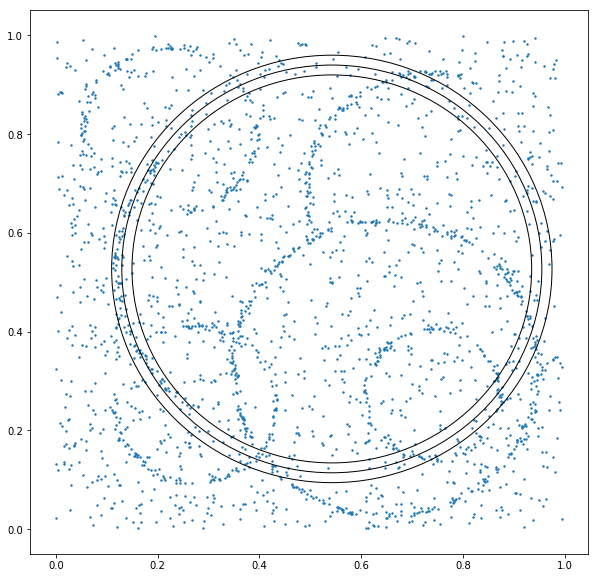

In [224]:
circle1, inliers1, outliers1 = ransac(circles, epsilon=0.02, n_tries=300)

## 7.3.2) fitting a circle by minimizing algebraic distance

In [216]:
def alg_fit(data, plotting=True):
    
    #transformations
    x = np.array([data[:,0], data[:,1], np.full(data.shape[0], 1)]).T
    y = norm(data, axis=1)
    #print('x:', x[0:10])
    #print('y:', y[0:10])
    
    #solving least squares of transfromed variables
    beta, _, _, _ = lstsq(x, y)
    #print('beta:', beta)
    #print(beta.shape)
    
    #backtransforming to get original parameters
    c_x = beta[0] / 2
    c_y = beta[1] / 2
    c = np.array([c_x, c_y])
    r = np.sqrt(beta[2] + norm(c))
    #print(c, r)
    
    if plotting:
        circle_fit = plt.Circle((c_x, c_y), radius=r, fill=False)
        plt.figure(figsize=(10, 10))
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.scatter(inliers[:,0], inliers[:,1])
        plt.gca().add_patch(circle_fit)
        plt.show()
        
    return c_x, c_y, r

0.489442973313 0.489442973313
[ 0.43608164  0.22223237] 0.731903414891


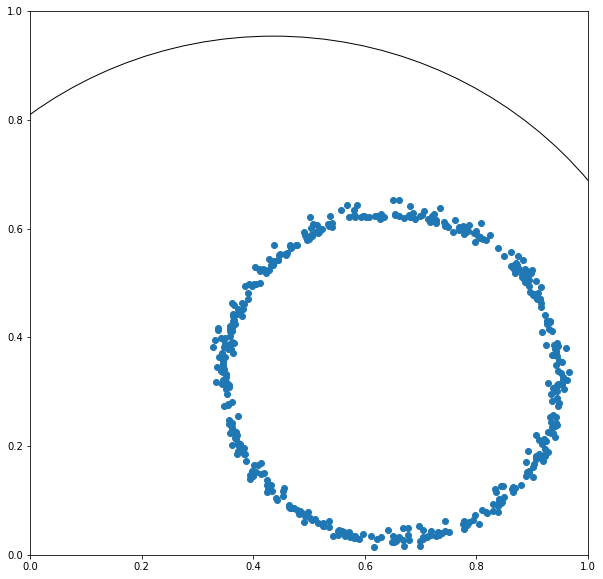

In [218]:
c1, c2, r = alg_fit(inliers)